In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import re
import nltk

In [2]:
fake= pd.read_excel('fake.xlsx')
true= pd.read_excel('true.xlsx')

In [3]:
fake.shape

(1092, 2)

In [4]:
true.shape

(1506, 2)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(2598, 3)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,no,news,target
0,203,Hoggaamiyihii hore ee Myanmar Aung San Suu Kyi...,true
1,1197,Ra’iisul Wasaare Maxamed Xuseen Rooble ayaa ka...,true
2,678,Deg deg Xog Xasaasi ah Rooble Iyo Ilama Adeera...,fake
3,521,Shimon Peres oo ahaa Siyaasiga rug caddaaga ah...,true
4,854,Waxaa maanta magaalada Muqdisho lagu qabtay Mu...,true


In [9]:
# Removing the No (we won't use it for the analysis)
data.drop(["no"],axis=1,inplace=True)
data.head()

,news,target
0,Hoggaamiyihii hore ee Myanmar Aung San Suu Kyi...,true
1,Ra’iisul Wasaare Maxamed Xuseen Rooble ayaa ka...,true
2,Deg deg Xog Xasaasi ah Rooble Iyo Ilama Adeera...,fake
3,Shimon Peres oo ahaa Siyaasiga rug caddaaga ah...,true
4,Waxaa maanta magaalada Muqdisho lagu qabtay Mu...,true


In [10]:
# Convert to lowercase

data['news'] = data['news'].apply(lambda x: x.lower())
data.head()

,news,target
0,hoggaamiyihii hore ee myanmar aung san suu kyi...,true
1,ra’iisul wasaare maxamed xuseen rooble ayaa ka...,true
2,deg deg xog xasaasi ah rooble iyo ilama adeera...,fake
3,shimon peres oo ahaa siyaasiga rug caddaaga ah...,true
4,waxaa maanta magaalada muqdisho lagu qabtay mu...,true


In [11]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['news'] = data['news'].apply(punctuation_removal)

In [12]:
# Removing stopwords
stop_words_to_lower = []
stopwords = [
    "Waxaan","wuxuu","iyo","ku","oo","aad","aan","een","ee","soo","ka","uu","ay","ey","marka","waxaa","waxa","wax","in","ah","ayo","mr","u","isu","iyo","waa","ayaa","mid","isku","taasi","la","Muxuu","maxay","inta","uun","uma","sidii","ugu","mar","kasoo","si","hor","ma","balse","e","waxayna","inuu","sii","is","miyuu","U","inay","ayuu","ke","jira","jirtey","kale","lagu","laga","kaliya","jeer","looga","qaab","cusub","labada","ayey","ayay","sida","waayey","manta","maanta","maalin","maalinta","mida","shalay","jirta","xa","doonaa","dona"]
for element in range(len(stopwords)):
    stop_words_to_lower.append(stopwords[element].lower())

In [13]:
corpus_message = []
for i in range(0, len(data)):
    message = re.sub('[^a-zA-Z]', ' ', str(data['news'][i]))
    message = message.lower()   
    message = message.split()
    
    message = [word for word in message if not word in stop_words_to_lower]
    message = ' '.join(message)
    corpus_message.append(message)

target
fake    1092
true    1506
Name: news, dtype: int64


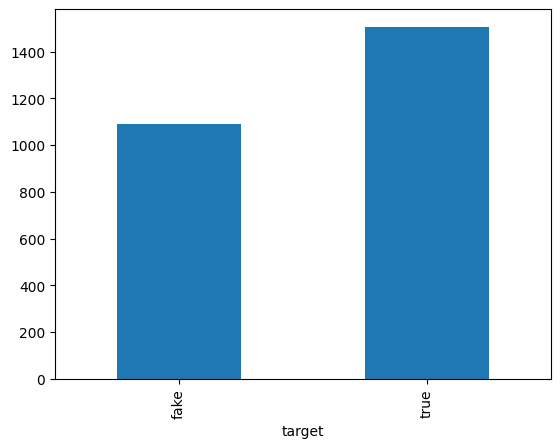

In [14]:
# How many fake and real articles?
print(data.groupby(['target'])['news'].count())
data.groupby(['target'])['news'].count().plot(kind="bar")
plt.show()

In [15]:
# Most frequent words counter  
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()
data['news']=corpus_message

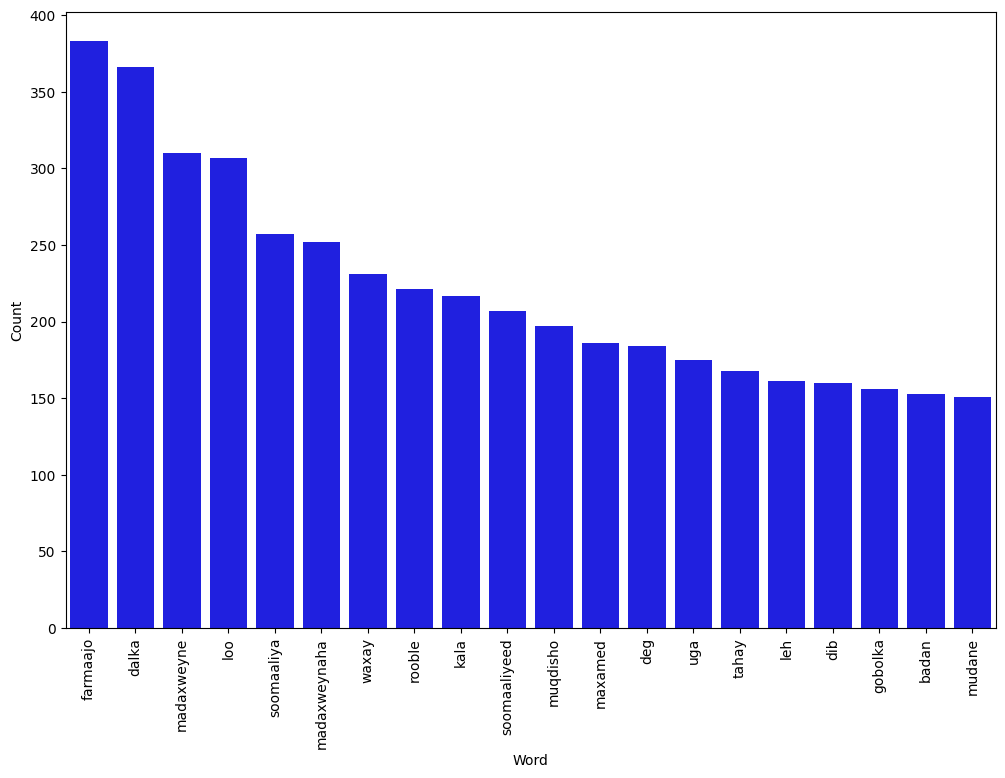

In [16]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "news", 20)

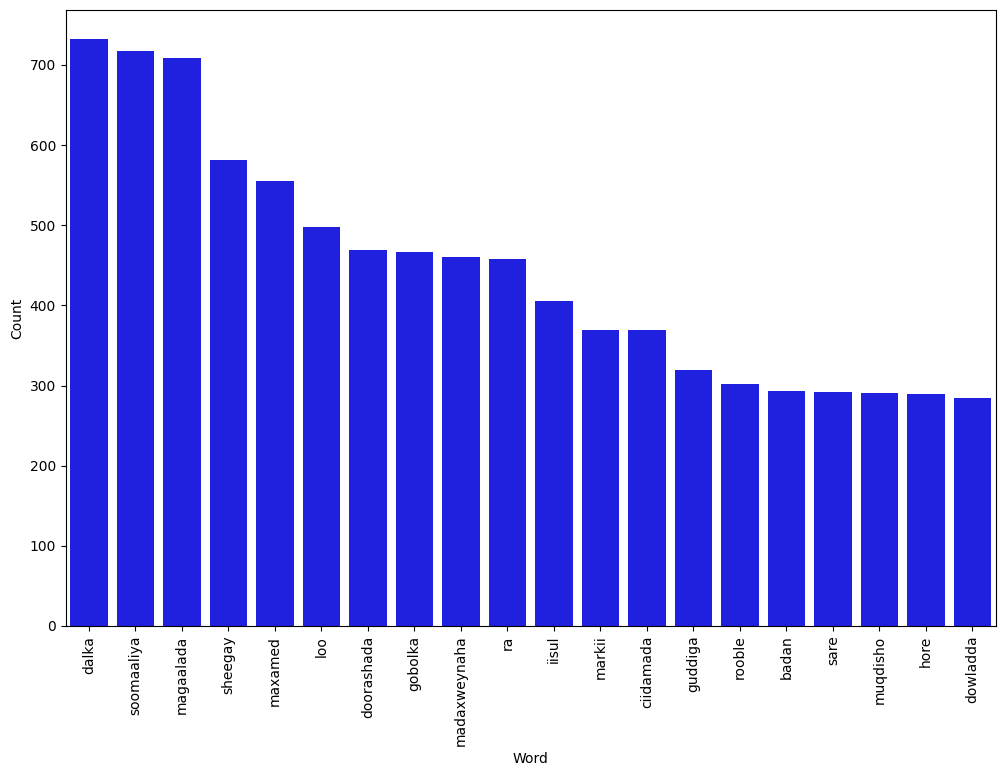

In [17]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "news", 20)

In [18]:
corpus_message

['hoggaamiyihii hore myanmar aung san suu kyi xukumay afar sano xarig waana markii horeysay xukun noocan rido',
 'ra iisul wasaare maxamed xuseen rooble hadlay arimmo kala duwan yihiin khilaafka gobolka gedodoorashooyinka dalkaxayiraadaha rogo siyaasiyiinta diyaaradaha hankiisa siyaasadeed maxamed xuseen rooble hadlay munaasabad kaga guddoomay guddiga dib heshiisiinta gobolka gedo xaliyeen khilaafka jirey gobolkaas umahadcelinayaa guddiga dib heshiisiinta gobolka gedo koobanaa wasiirada arrimaha gudaha maamul goboleedyada dalkawaxayna guuleysteen xaaladihii jirey gobolka gedo yiri ra iisul wasaare rooble sheegay ra iisul wasaaraha arrinta gobolka gedo harsan tahay wareegto wada saaraan ra iisulwasaaraha madaxweynaha jubbaland madaxda degmada garbahaarey xaqiiinayaa qodobkana gedo caqabad ahaa heshiiskii september gabagabeeyay harsan tahay wareegto saaro maamulka degmada garbahaarey yiri ra iisul wasaaraha isagoo hadlayay arrimaha safarada siyaasiyiinta dalka dhowaan siyaasiyiin celiyay

#### lematazation of the text

In [19]:
train_words = {
"xidhiidhka" :"xadhiidh",
"magacowday":"magacaabid", 
"garsooraha" :"garsoor",
"kulanka" :"kulan",
"kulamadeedii":"kulan",
"isniinta":"isniin",
"dhexdhexaadiyo " :"dhexdhexaad",
"talyaaniga " :"talyaani",
"kooxoodba " :"koox",
"ciyaareedkan " :"ciyaar",
"ciyaartoy" :"ciyaar",
"burburisay " :"burbur",
"canaantay ":"canaan" ,
"xiddigihiisa " :"xidig",
"dhacdooyinkii " :"dhacdo",
"maalintii " :"maalin",
"kaalintii":"kaalin", 
"dareemayay " :"dareen",
"warbaahinta " :"warbaahin",
"galkiisa " :"gal",
"shaaciyay ":"shaacin",
"musharaxiinta " : "musharax",
"doorashadoodu " :"doorasho", 
"guuleysatay ":"guul" ,
"heshiiskii ":"hishiis",
"xildhibaanada " :"xildhibaan",
"baarlamaanka ":"baarlamaan",
"liiska ":"liis",
"tirsigiisu ":"tirsi",
"saraakiil " :"sargaal",
"tuhmeysay" :"tuhun",
"xiisaddii " :"xiisad",
"yareeyey " :"yare",
"ciidamada ":"ciidan", 
"soomaaliya " :"soomaali",
"sababo " :"sabab",
"xariirta" :"xariir", 
"tanaasulay " :"tanaazul",
"shaaciyeen":"shaacin", 
"noqday":"noqosho", 
"ahaa" :"ahaansho",
"kordhiyo":"kordhin", 
"sheegtay":"sheegid",
"dilay":"dil",
"madaxwaynaha":"madaxwayne",
"dhintay":"dhimasho",
"Booqday":"Booqasho",
"musharixiinta":"musharax",
"khudbadiisa":"khudbad",
"Jeediyay":"Jeedin",
"Siyaasiyiinta":"Siyaasi",
"Tiraddii":"Tiro",
"sharafkaas":"sharaf",
"Hogaamin ":"Hogaan",
"Faanay ":"Faan",
"Deegaankiisa ":" Deegaan",
"Yiraahda ":"Yiri",
"Cabsaday ":"Cabsi",
"Jeediyay ":"jeedi",
" Midnimada ":"Midnimo",
"Heshiisiinta ":"Heeshiis",
"Filayaa":"Filasho",
"Xuduudaha":"Xuduud",
"Dhaqaalaha":"dhaqaale",
"Amniga":"Amni",
"Hirgalinta ":" Hirgalin",
"Wakhtigeeda":"Wakhti",
"Guulaysto":"Guul",
" Kurisga":" Kursi",
"Boorriyay":" Boorrin",
" Kulankaas":" Kulan",
" danaha":" dan",
"  Ururka":"  Urur",
" gudoonsiiyay":" gudoon",
" Gobollada ":" Gobol",
" shiray":" Shir",
"Dilaalaan ":" Dilal",
" maalinta ":" maalin",
" billowday ":" billow",
" Mucaaradku ":"Mucaarad",
"  jeedintoodu":"  jeedin",
 "Baarlamaanka":"Baarlamaan",
 "   shacabku":"   shacab",
 "  jawaabo":"jawaab",
 " hadlin":"  hadal",
 " Su’aalaha":"  Su’aal",
 " sugayeen":"  sugid",
 " Dadweynaha":"  dad",
 " Dhiibistii":"  Dhiibid",
 "  weeraray":"   weerar",
 "  kaliftay":"   kalif",
 " Dhiibistii":"  Dhiibid",
 " Ciidamadii":"  Ciidan",
 "Tiradooda":"  Tiro",
 " qaaday":"  qaad",
 " galeen ":"  gal",
 " noolal":"  nool ",
 " geeriyootay":"geeri",
 "joojiyey":"jooji",
 "Carqaladaynayo":"Carqalad",
 "dhagaysiga":"dhagaysi",
 "guddoomiyihii":"guddoomiye",
 " wakiiladda":" wakiil",
 "  maamulkaas":"  maamul",
 " Cafiyay":" Cafin",
 " kulmay":" kulan",
 "  isgarabsi":"garab",
 "  tirsan":"  tiro",
 " taageerayaasha":"  taageere",
 "  Koowaad":"   Kow",
 " kulantay":"  kulan",
 "Dhammeystirka":"  dhame",
 "hadlayo":"  hadal",
 "mahadcelisay":"  mahadcelin",
 "badbaadiyo":"  badbaadin",
 "Hoggaamineed":"  Hoggaan",
 "noociisu":"  nooc",
 "gaariggaas":"  gaari",
 "qoriga":" qori",
 "Xog-ogaal":" Xog",
 "xaqiijiyay":" xaqiiq",
 "dhacdadaas ":" dhacdo",
 "dhaawacay ":" dhaawac",
 "fakarno ":" fakar",
 "Astaanta ":" Astaan",
 "Wargaysyada ":" Wargays",
 "Amniga ":" Amni",
 "Hiliyay ":"Hiilin",
 "dabaaldegaayo ":" dabaaldag",
 "dulqaadka ":" dulqaad",
 "dulmigii ":" dulmi",
 "dhaliisha  ":"dhaliil",
 "taageerada  ":"taageere",
 "dhaliisha  ":"dhaliil",
 "codkaada  ":"cod",
 "Dheefta  ":"Dheef",
 " dhididay  ":" dhidid",
 " deegaanka  ":"deegaan",
 " hurdada  ":" hurdo",
 " adeegsanayo  ":" adeeg",
 "  werinayo ":" war",
 " dagaalku  ":" dagaal",
 " dhawaaqa  ":" dhawaaq",
 " cadcad ":" cad",
 "doorashooyinka":" doorashada",
 " hawl-gelintii ":" hawl",
 " baahannyahay":" baahi",
 " qaraxyo ":"qarax",
 " Dhaqaalaha":" dhaqale",
 " muuqaalada":" muuqal",
 " dhaqmay":" dhaqan",
 " abaabulan":" abaabul",
 " badali":" badal"


}

In [20]:
# words to their original
new_corpus = []
for i in corpus_message:
    row = i.split()
    for j in range(len(row)):
        if row[j] in train_words.keys():
            row[j] = train_words[row[j]]
    new_corpus.append(' '.join(row))

In [21]:
data['news'] = new_corpus

In [22]:
data.head(10)

,news,target
0,hoggaamiyihii hore myanmar aung san suu kyi xu...,true
1,ra iisul wasaare maxamed xuseen rooble hadlay ...,true
2,deg deg xog xasaasi rooble ilama adeeradii dow...,fake
3,shimon peres ahaansho siyaasiga rug caddaaga r...,true
4,magaalada muqdisho qabtay munaasabad bandhigay...,true
5,heshiiskii nabadda oslo doorashadii peres laga...,true
6,gaaray guushii weyneyd ciidanka dowlada buuxda...,fake
7,shirka arimaha qaxootiga furmay magalada genev...,fake
8,mucaaradka ilaa hada fahmi layahiin siyaasada ...,fake
9,lafta gareen wa legend walahi waaba diiday fad...,fake


### bag of words model

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# get bag of words features in sparse format
bow_cv = CountVectorizer(min_df=0., max_df=1.)
bow_cv_matrix = bow_cv.fit_transform(data['news'])
bow_cv_matrix

<2598x23545 sparse matrix of type '<class 'numpy.int64'>'
	with 113243 stored elements in Compressed Sparse Row format>

### showing the table of the frequency

In [24]:
#converting into numpy array
cv_matrix_bow = bow_cv_matrix.toarray()
# get all unique words in the corpus
# vocab = bow_cv.get_feature_names()........replace to out 
vocab = bow_cv.get_feature_names_out()

# show document feature vectors
pd.DataFrame(cv_matrix_bow, columns=vocab)

,aa,aaad,aaan,aab,aabaha,aabaheed,aabaheedna,aabayoowga,aabbayaashood,aabbeyaashii,...,zelensky,zenawi,zimbabwe,zo,zolotov,zoomka,zrh,zuma,zumasambudla,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Bag of N-Grams Model

In [25]:
# you can set the n-gram range to 2,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(data['news'])

bv_matrix = bv_matrix.toarray()

# vocab = bow_cv.get_feature_names_out()
vocab = bv.get_feature_names_out()

# vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,aa lay,aa muddo,aaad marna,aaad ogsoon,aaan idin,aab ahay,aabaha dhalay,aabaha kuuriyada,aabaha saxaafada,aabaheed beeniyay,...,zuma maxkamadda,zuma muddo,zuma sheegay,zuma tallaabadan,zuma todobaadki,zuma weeraray,zuma xukunka,zuma yiri,zumasambudla goor,zurich airport
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF Model

In [26]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X = cv.fit_transform(data['news']).toarray()

In [27]:
import numpy as np
# get all unique words in the corpus
# vocab = cv.get_feature_names()
vocab = cv.get_feature_names_out()

# show document feature vectors
pd.DataFrame(np.round(X, 2), columns=vocab)

,aa,aaad,aaan,aab,aabaha,aabaheed,aabaheedna,aabayoowga,aabbayaashood,aabbeyaashii,...,zelensky,zenawi,zimbabwe,zo,zolotov,zoomka,zrh,zuma,zumasambudla,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create training and test sets
###  dataset will splitted into train and test data, 70/30 ratio

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [29]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [30]:
# Convert to lowercase

data['news'] = data['news'].apply(lambda x: x.lower())
data.head()

,news,target
0,hoggaamiyihii hore myanmar aung san suu kyi xu...,true
1,ra iisul wasaare maxamed xuseen rooble hadlay ...,true
2,deg deg xog xasaasi rooble ilama adeeradii dow...,fake
3,shimon peres ahaansho siyaasiga rug caddaaga r...,true
4,magaalada muqdisho qabtay munaasabad bandhigay...,true


In [31]:
# getting the target
y=pd.get_dummies(data['target'])
y=y.iloc[:,1].values

In [32]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Build three machine learning classifiers
## Use a cross-validation method to separate the dataset into a 5-fold training procedure.
## Build three machine learning classifiers such as logistic regression, random forest or support vector machine

# Evaluate each model
## Compute each metric on each fold and compute their average (mean) Compare the results of the three classifiers by using Accuracy metri

# LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [34]:
model.fit(X_train, y_train)

LogisticRegression()

In [35]:
X_train_prediction = model.predict(X_train)

In [36]:
training_data_accuracy = accuracy_score(X_train_prediction, y_train)

In [37]:
print(f'Accuracy score of training data  :{round(training_data_accuracy*100,2)}%')

Accuracy score of training data  :97.55%


In [38]:
X_test_prediction = model.predict(X_test)
testing_data_accuracy = accuracy_score(X_test_prediction, y_test)

In [39]:
print(f'Accuracy score of testing data :{round(testing_data_accuracy*100,2)}%')

Accuracy score of testing data :94.23%


In [40]:
#from sklearn.multiclass import OneVsOneClassifier
#from sklearn.svm import SVC
#2. Support Vector Machine(SVM) - SVM works relatively well when there is a clear margin of separation between classes.
#svm_model = OneVsOneClassifier(SVC(kernel = 'linear', random_state = 100))

#Fitting training set to the model
#svm_model.fit(X_train, y_train)

#Predicting the test set results based on the model
#svm_y_pred = svm_model.predict(X_train)

#Calculate the accuracy score of this model
#score = accuracy_score(svm_y_pred,y_train)
#print(f'Accuracy of SVM model is: {round(training_data_accuracy*100,2)}%')

In [41]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


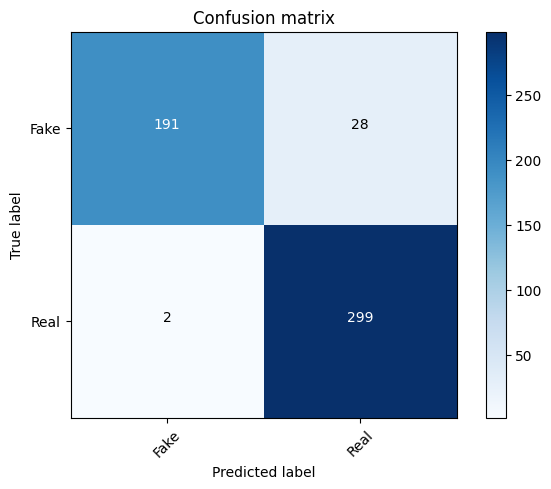

In [42]:
cm = metrics.confusion_matrix(y_test, X_test_prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# naive_bayes

In [43]:
#  naive_bayes object
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB(alpha=0.8)
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.8)

In [44]:
# predict on train data
X_train_predict = nb_model.predict(X_train)
# train_accuracy
train_accuracy1 = accuracy_score(y_train, X_train_predict)

# predict on test data
X_test_predict1 = nb_model.predict(X_test)
# test_accuracy
test_accuracy1 = accuracy_score(y_test, X_test_predict1)


In [45]:
print(f'Accuracy score of training data : {round(train_accuracy1*100,2)}%')

Accuracy score of training data : 94.08%


In [46]:
print(f'Accuracy score of Testing data :{round(train_accuracy1*100,2)}%')

Accuracy score of Testing data :94.08%


Confusion matrix, without normalization


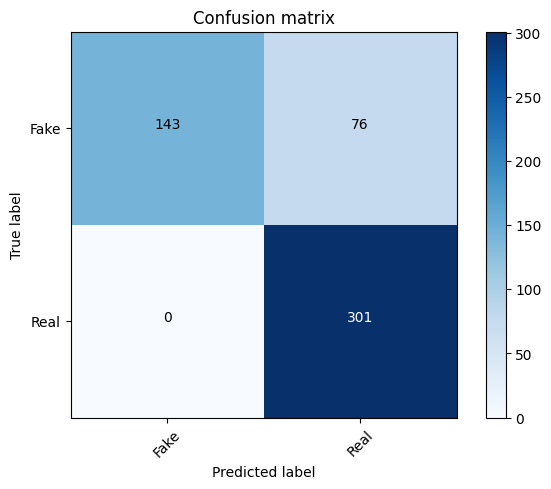

In [47]:
cm = metrics.confusion_matrix(y_test, X_test_predict1)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [48]:
# As SVM is able to provide best results - SVM will be used to check the news liability

def fake_news_det(data):
    input_data = {"news":[data]}
    new_def_test = pd.DataFrame(input_data)
    #new_def_test["news"] = new_def_test["news"].apply(wordopt) 
    new_x_test = new_def_test["news"]
    #print(new_x_test)
    vectorized_input_data = cv.transform(new_x_test)
    prediction = model.predict(vectorized_input_data)
    
    if prediction == 1:
        print("Not a Fake News")
    else:
        print("Fake News")

In [49]:
fake_news_det("Maxbuus Siyaasad loo xiro Soomaaliya kii ugu waqtiga dheeraa!  Muxuu iiga sheekeeyey Mukhtaar Roobow, kulankeennii maanta? December 13, 2018-kii ayaa Baydhaba laga soo afduubay sida uu warka iigu billaabay Mukhtaar Roobow oo ahaa Musharrax ay muuqatay Guushiisa. Waxaana cabsidii laga qabay guushiisa dhaweyd ay dhaxal siisay in Xabsiga loo taxaabo bilaa sharci. Qof ahaantayda waxay ii aheyd markii Labaad oo aannu kullano, kulanka koowaad ee is araggeenna wuxuu dhacay mar uu shir jaraa'id uu ku qabtay Xamar isagoo caddeynayey mowqifkiisa iyo katagiddiisii AS. Waa sheeko yaqaan taabta dulucda warka, waana nin wadaad ah sida ka muuqata Kitaabadda Culuumta diiniga ah ee yaalla halka uu ku nool yahay. Wuxuu iisheegay in si ka baxsan bini'aadanimadda uu ula dhaqmay nidaamkii hayey taladda Wadanka ee laga adkaaday, waxaa loo diiday Sodohdiis oo Xanuunsan inuu booqdo, way dhimatay waana loo diiday inuu janaasada ka qeyb galo ama uu ka soo Tacsiyeeyo oo la geeyo guriga reerkiisa. Waxbarasho uu waday xitaa waa loo diiday inuu dhammeystirto. Isagoo qiireysan oo hadalka xitaa kari la ayuu si qiiro leh igu yiri Cali anigoo ah Muwaadin ayey Ciidankii Itoobiya ee Baydhaba joogay igu qadarin waayeen Madax bannaanida Wadankayga iyo qof ahaantayda, waxay qaateen ￼Diplomacy Passabort-kii dowladdu isiisay oo aan kusoo xajiyey waddamo kale na aan ku tagay Kabihii way iga Furteen, Xamar waxay ikeeneen anigoo wata kaliya SIGISAANTA KABAHA. Ra'iisul Wasaare Rooble ayuu ku ammaanay kaalintiisa adkeysiga iyo inuu kursi la'aan abaalmarin uga dhigay kuwii ihaaneystay Mukhtaar Roobow. Mar labaad ayaan idin la wadaagayaa, sheekaddeenna  oo dheer iyo Aqriska oo Badankood Soomaalidu aysan jecleyn, waxaan garowsaday inaan soo yareeyo warkayga qoraalka ah. Maxaa dhexmaray Fahad iyo Mukhtaar Roobow?  Askarta Xabsigu mala shaqeyn jirtay Roobow? Iyo jawaabaha Su'aalo kale oo aan ka sheekeysannay dib ayaan idin kala wadaagayaa.")

Fake News


In [50]:
from sklearn.metrics import classification_report
print(classification_report(X_test_prediction, y_test))

              precision    recall  f1-score   support

       False       0.87      0.99      0.93       193
        True       0.99      0.91      0.95       327

    accuracy                           0.94       520
   macro avg       0.93      0.95      0.94       520
weighted avg       0.95      0.94      0.94       520



In [51]:
# save model
import pickle
filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [52]:
# save vectorizer
filename = 'vectorizer.pkl'
pickle.dump(cv, open(filename, 'wb'))